In [1]:
import sys
import os
sys.path.append(os.path.abspath("..")) 

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import scipy.signal as signal

from pySNA import *

# old G5P5
# baseline = 277e-12 #加/减去offset之后的baseline
# var = 2e-12
#offset= 5e-12
# new G5P5
baseline = 250e-12 #加/减去offset之后的baseline
var = 2e-12
offset= -2e-12
threshold = baseline*0.5
pySNA = PySNA(baseline=baseline, var=var, threshold=threshold)

In [2]:
# old G5P5
# file_path = "/data/nas-shared/liurh/研究生科研总结/何淑君/MEILI_NANOPORE_DATA/梅丽MspA及突变体原始数据/M2/D91N/梅丽buffer_NaCl置换成KCl/5G/(黄赤血盐+K盐buffer_D91N_180mV_5T5G32T)20250702111110.dat"
# new G5P5
file_path = "/data/nas-shared/liurh/研究生科研总结/何淑君/MEILI_NANOPORE_DATA/梅丽MspA及突变体原始数据/M2/D91N/梅丽buffer_NaCl置换成KCl/5G/(黄赤血盐+K盐buffer_D91N_180mV_5T5G30T)20250812150501.dat"

# 加载数据
pySNA.load(file_path, output_samplerate=10000., lp_filter_cutoff=2500.)
pySNA.data = pySNA.data+offset

2025-08-14 12:39:05,257 - INFO - Successfully loaded .dat file: /data/nas-shared/liurh/研究生科研总结/何淑君/MEILI_NANOPORE_DATA/梅丽MspA及突变体原始数据/M2/D91N/梅丽buffer_NaCl置换成KCl/5G/(黄赤血盐+K盐buffer_D91N_180mV_5T5G30T)20250812150501.dat
2025-08-14 12:39:05,331 - INFO - Data filtered with LP filter cutoff: 2500.0 Hz
2025-08-14 12:39:05,391 - INFO - Baseline = 36.45 pA, RMS = 45.16 pA


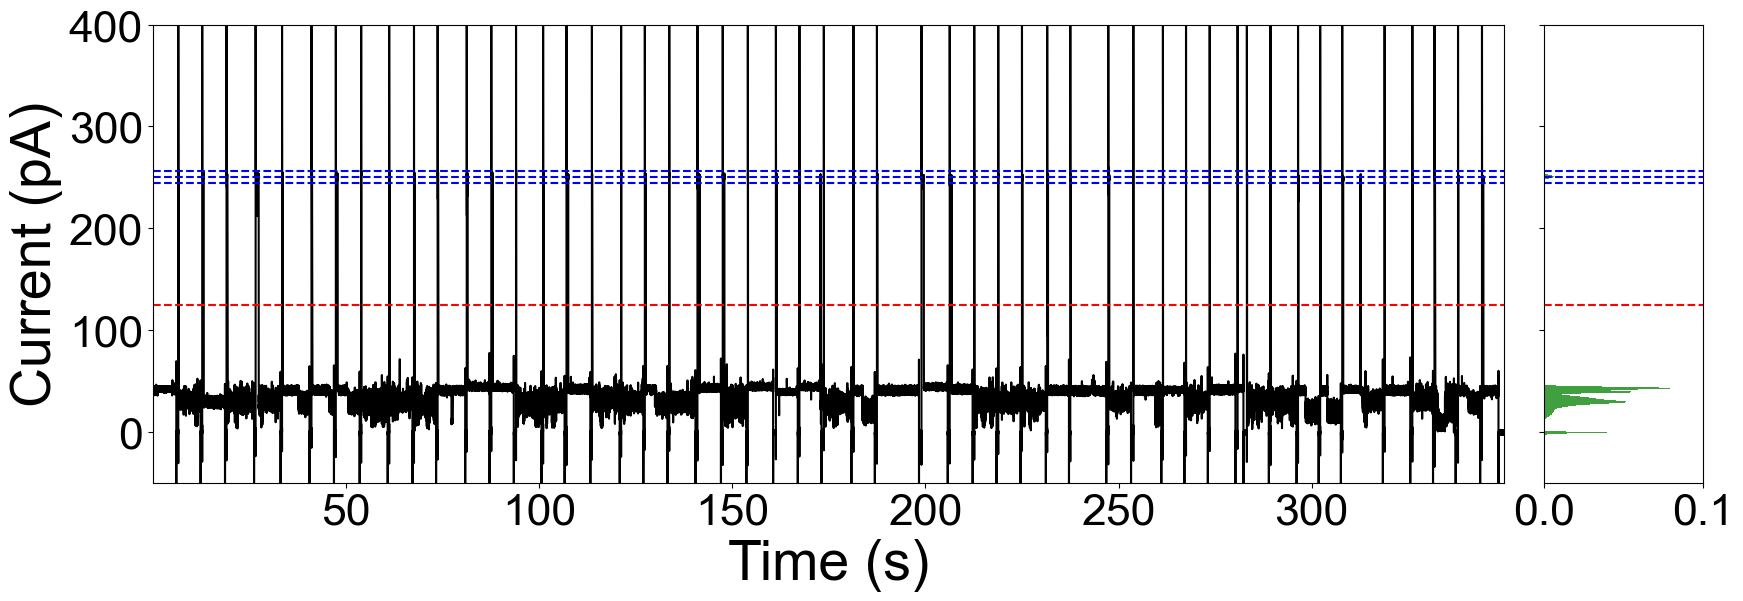

In [3]:
pySNA.plot_temporal_and_hist(analyzed=False,ylim=[-50,400],color='g',hist_scale=0.1)

In [4]:
# Step 1: Find all points below the threshold
below = np.where((pySNA.data < pySNA.threshold) & (pySNA.data > 1e-12))[0]

# Step 2: Locate event start and end points
startandend = np.diff(below)
startpoints = np.insert(startandend, 0, 2)
endpoints = np.insert(startandend, -1, 2)

startpoints = np.where(startpoints > 1)[0]
endpoints = np.where(endpoints > 1)[0]

startpoints = below[startpoints]
endpoints = below[endpoints]

temp = endpoints-startpoints
startpoints = startpoints[temp > 2e3]
endpoints = endpoints[temp > 2e3]


endpoints = endpoints[ pySNA.data[startpoints-10] > pySNA.threshold ]
startpoints = startpoints[ pySNA.data[startpoints-10] > pySNA.threshold ]

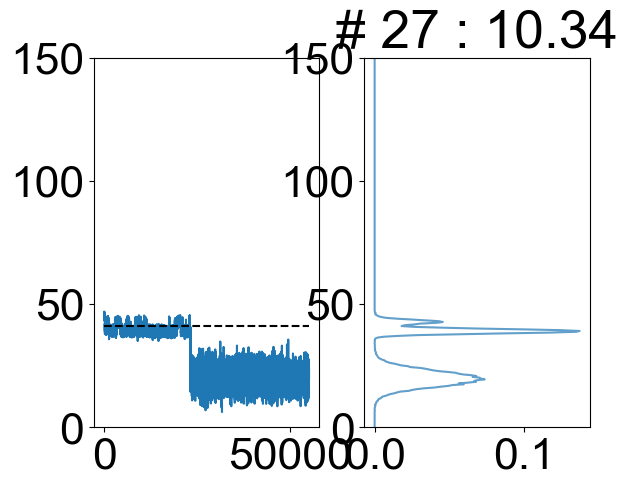

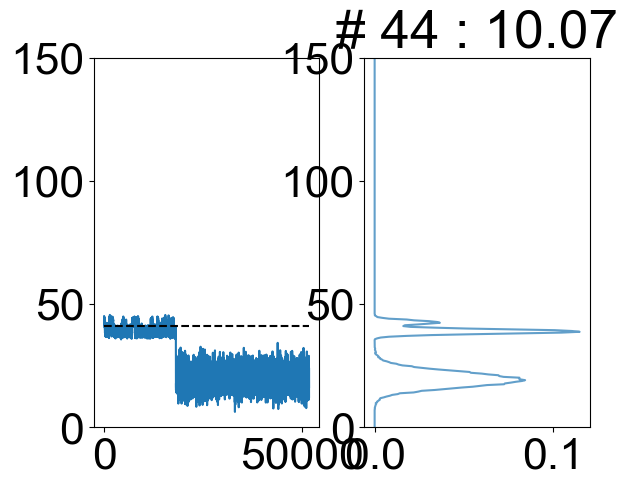

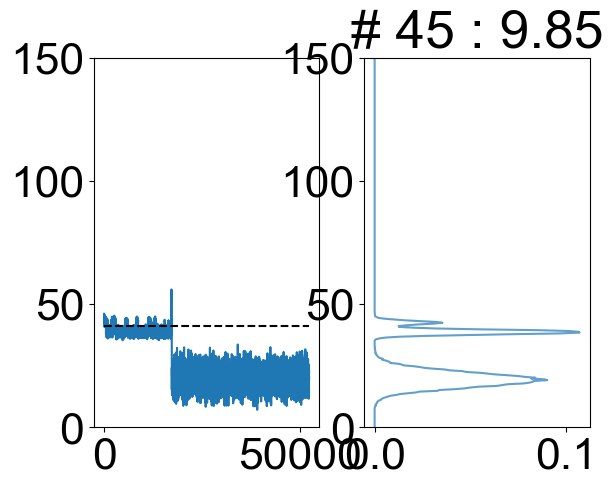

53


In [5]:
from scipy.optimize import curve_fit

# 定义高斯函数用于拟合
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))
    
peak_position = []
peak_width = []
segment_median = []
segment_mean = []
segment_std = []
segment_dwell = []

for j in range(len(startpoints)):
    segment = pySNA.data[startpoints[j]+50:endpoints[j]-50]*1e12
    segment_median.append(np.median(segment)/pySNA.baseline/1e12)
    segment_std.append(np.std(segment))
    
    #if np.std(segment) > 10 :
    if np.median(segment)/pySNA.baseline/1e12 < 0.1 :
        plt.subplot(1,2,1)
        plt.plot(segment)
        plt.hlines(y=41,xmin=0,xmax=len(segment),colors='k',linestyles='--') #TTTT
        plt.ylim([0,150])    
        # 绘制包络线
        plt.subplot(1,2,2)
        hist, bins = np.histogram(segment, bins=451, density=True, range=(0, 150))
        bin_centers = (bins[:-1] + bins[1:]) / 2  # 计算每个 bin 的中心位置
        plt.plot(hist, bin_centers, alpha=0.7)
        plt.ylim([0,150])
        plt.title(f"# {j} : {np.std(segment):.2f}")
        plt.show()
        
startpoints = startpoints[(np.array(segment_median) > 0.05) & (np.array(segment_median) < 0.45) & (np.array(segment_std) < 50)]
endpoints = endpoints[(np.array(segment_median) > 0.05) & (np.array(segment_median) < 0.45) & (np.array(segment_std) < 50)]

pySNA.startpoints = startpoints
pySNA.endpoints = endpoints
print(len(startpoints))

peak_position = []
peak_width = []
segment_median = []
segment_mean = []
segment_std = []
segment_dwell = []

for j in range(len(startpoints)):
    #print(j)
    segment = pySNA.data[startpoints[j]+50:endpoints[j]-50]*1e12
    segment_dwell.append(((endpoints[j]-50) - (startpoints[j]+50))/1e4)
    segment_median.append(np.median(segment)/pySNA.baseline/1e12)
    segment_mean.append(np.mean(segment)/pySNA.baseline/1e12)
    segment_std.append(np.std(segment))
    
    # 拟合高斯函数
    try:
        hist, bins = np.histogram(segment, bins=451, density=True, range=(0, 150))
        bin_centers = (bins[:-1] + bins[1:]) / 2  # 计算每个 bin 的中心位置
        popt, _ = curve_fit(gaussian, bin_centers, hist, p0=[max(hist), bin_centers[np.argmax(hist)], 10])
        peak_position.append(popt[1])
        peak_width.append(popt[2] * 2.355)  # 半峰宽 = 2.355 * sigma
    except RuntimeError:
        print(f"Segment {j}: Gaussian fitting failed.")
        continue

(-50.0, 150.0)

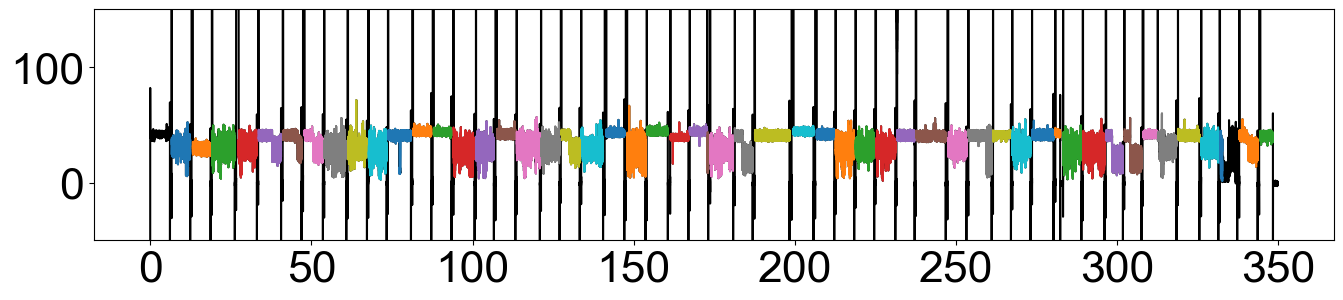

In [6]:
# 绘制直方图分布
plt.figure(figsize=(16, 3))

plt.plot(pySNA.t, pySNA.data*1e12, 'k')
for j in range(len(startpoints)):
    plt.plot(pySNA.t[startpoints[j]+50:endpoints[j]-50], pySNA.data[startpoints[j]+50:endpoints[j]-50]*1e12)

plt.ylim(-50,150)

(0.0, 50.0)

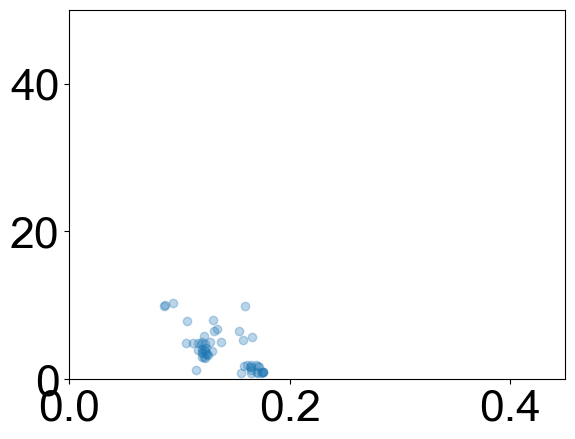

In [7]:
plt.scatter(segment_median,segment_std,alpha=0.3)
plt.xlim(0,0.45)
plt.ylim(0,50)

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([  0.    ,   0.9934,   1.9868, ..., 148.0132, 149.0066, 150.    ]),
 <BarContainer object of 151 artists>)

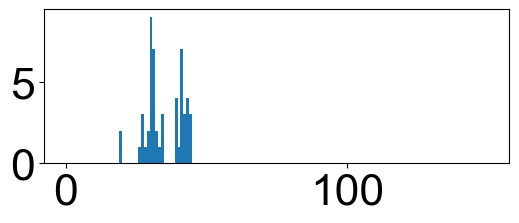

In [8]:
plt.figure(figsize=(6, 2))
plt.hist(peak_position, bins=151, density=False, range=(0, 150))

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([0.    , 0.005 , 0.0099, ..., 0.4901, 0.495 , 0.5   ]),
 <BarContainer object of 101 artists>)

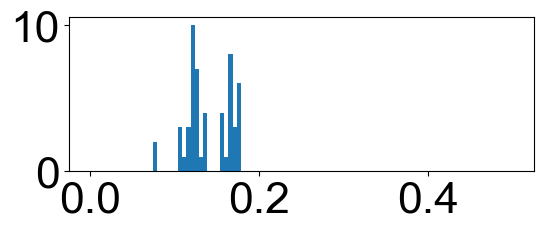

In [9]:
normalized_peak_position = [x / pySNA.baseline / 1e12 for x in peak_position]
plt.figure(figsize=(6, 2))
plt.hist(normalized_peak_position, bins=101, density=False, range=(0, 0.5))

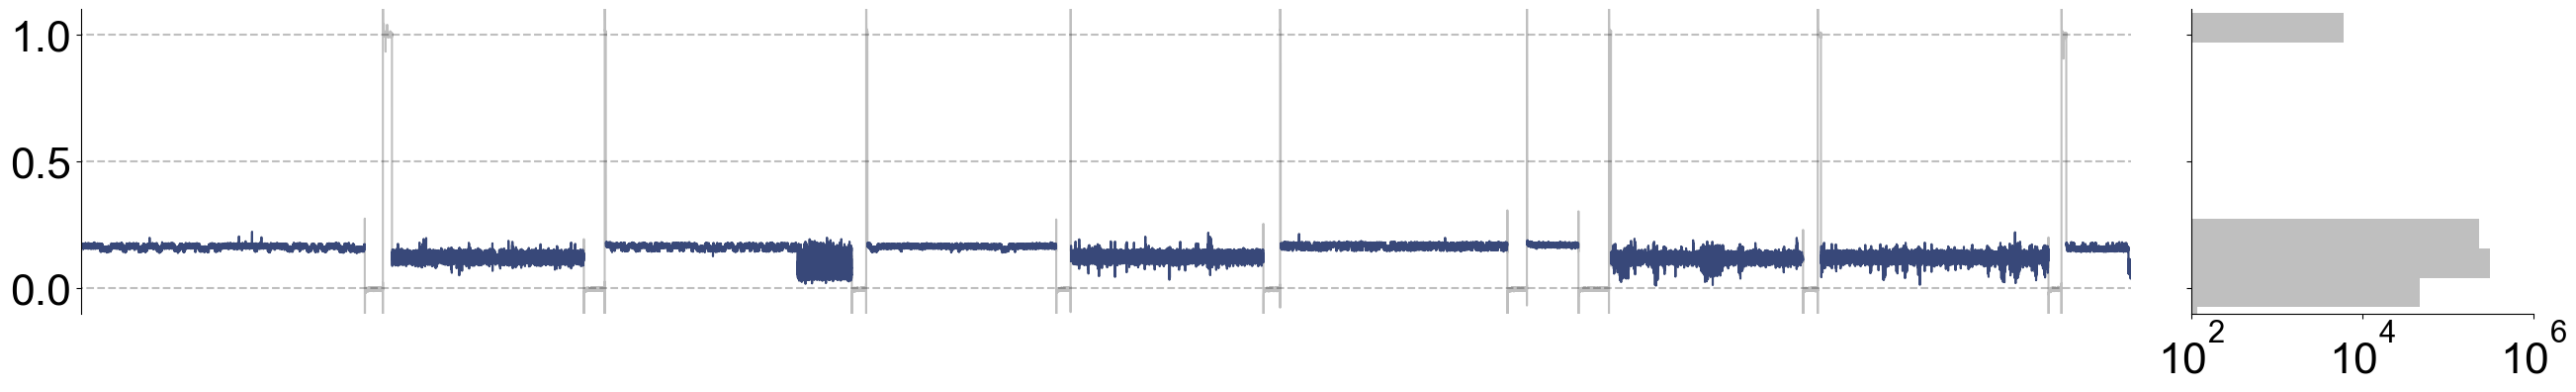

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------- 假设你已有变量 ---------------------
# pySNA.t, pySNA.data, pySNA.baseline, pySNA.startpoints, pySNA.endpoints
color = '#384879'

# --------------------- 计算每个事件的特征（例如持续时间）---------------------
durations = []  # 以时间为单位的持续时间
amplitudes = [] # 每个事件的最大信号强度（相对于 baseline）

for i in range(len(pySNA.startpoints)):
    start = pySNA.startpoints[i]
    end = pySNA.endpoints[i]
    duration = pySNA.t[end] - pySNA.t[start]
    durations.append(duration)
    
    # 提取该区间内的最大信号值（归一化后）
    max_signal = np.max(pySNA.data[start:end] / pySNA.baseline)
    amplitudes.append(max_signal)

# --------------------- 使用 gridspec 创建主图 + 右侧直方图 ---------------------
fig = plt.figure(figsize=(32, 4))  # 宽一点，给直方图留空间
gs = fig.add_gridspec(1, 2, width_ratios=[6, 1], wspace=0.05)

# --- 左图：原始信号图 ---
ax1 = fig.add_subplot(gs[0])
ax1.spines['left'].set_visible(True)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# 背景信号（浅色）
ax1.plot(pySNA.t[2:][:-2], pySNA.data[2:][:-2]/pySNA.baseline, color='k', alpha=0.25)

# 高亮每个事件
for i in range(len(pySNA.startpoints)):
    start_idx = pySNA.startpoints[i] + 50
    end_idx = pySNA.endpoints[i] - 50
    ax1.plot(pySNA.t[start_idx:end_idx], pySNA.data[start_idx:end_idx]/pySNA.baseline, color=color, alpha=1)

# 基线
ax1.plot([pySNA.t[2], pySNA.t[-2]], [1, 1], '--', color='k', alpha=0.25)
ax1.plot([pySNA.t[2], pySNA.t[-2]], [0.5, 0.5], '--', color='k', alpha=0.25)
ax1.plot([pySNA.t[2], pySNA.t[-2]], [0, 0], '--', color='k', alpha=0.25)

ax1.set_xlim([238.5,298.5])
ax1.set_ylim([-0.1, 1.1])
ax1.set_xticks([])
ax1.set_yticks([0.0, 0.5, 1.0])

# --- 右图：直方图（对数频次）---
ax2 = fig.add_subplot(gs[1])
ax2.spines['left'].set_visible(True)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
counts, bins, patches = ax2.hist(#pySNA.data[2:][:-2]/pySNA.baseline, 
                                 pySNA.data[np.int64(238.5*10**4):np.int64(298.5*10**4)]/pySNA.baseline,
                                 bins=121, 
                                 orientation='horizontal', 
                                 #color=color, alpha=0.75, 
                                 color='k', alpha=0.25,
                                 linewidth=0.5,
                                 log=True)  # <<< 对数频次

# 设置 y 轴和左图一致
ax2.set_xlim([1e2, 1e6])
ax2.set_ylim([-0.1, 1.1])
ax2.set_yticks([0.0, 0.5, 1.0])
ax2.set_yticklabels([])  # 可隐藏标签，或与左图一致

# 可选：添加 x 轴刻度
ax2.set_xticks([1e2, 1e4, 1e6])

#plt.savefig('ssDNA_trace_D91N_2023_03_10_0003.svg', format='svg',dpi=300)

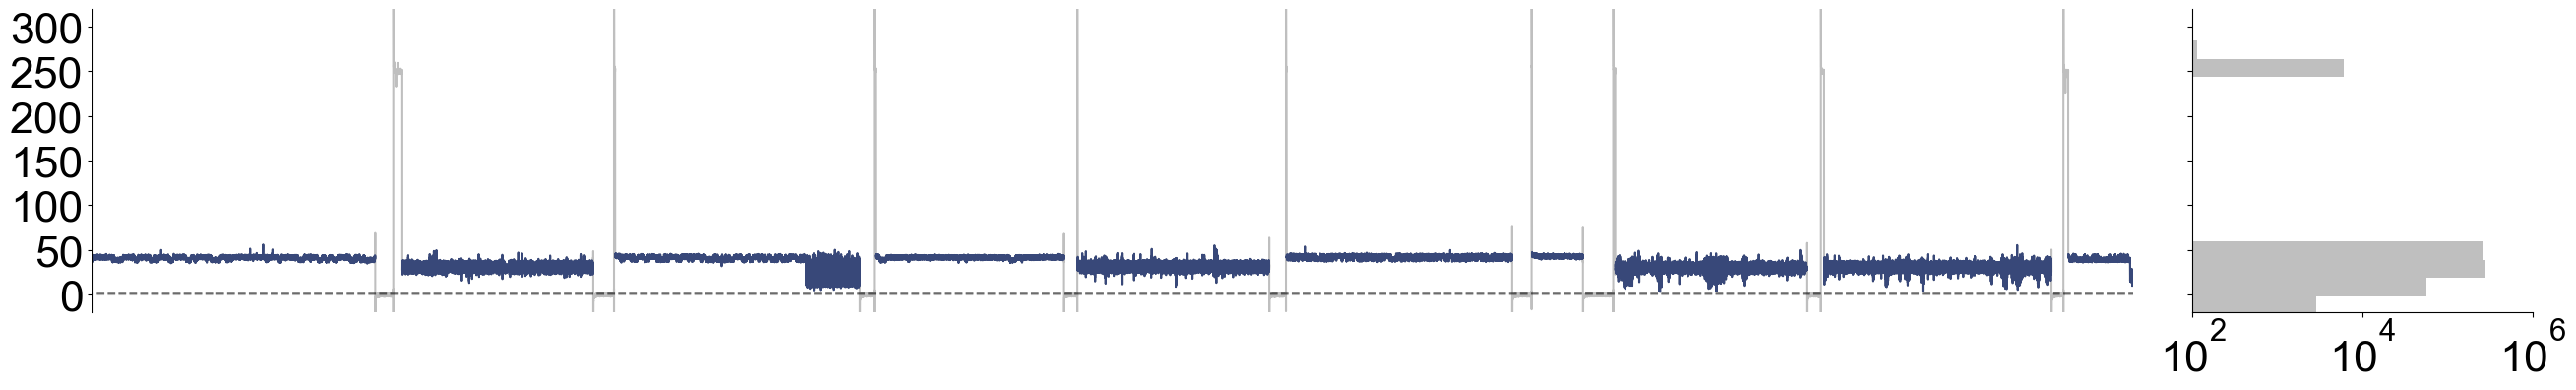

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------- 假设你已有变量 ---------------------
# pySNA.t, pySNA.data, pySNA.baseline, pySNA.startpoints, pySNA.endpoints
color = '#384879'

# --------------------- 计算每个事件的特征（例如持续时间）---------------------
durations = []  # 以时间为单位的持续时间
amplitudes = [] # 每个事件的最大信号强度（相对于 baseline）

for i in range(len(pySNA.startpoints)):
    start = pySNA.startpoints[i]
    end = pySNA.endpoints[i]
    duration = pySNA.t[end] - pySNA.t[start]
    durations.append(duration)
    
    # 提取该区间内的最大信号值（归一化后）
    max_signal = np.max(pySNA.data[start:end] / pySNA.baseline)
    amplitudes.append(max_signal)

# --------------------- 使用 gridspec 创建主图 + 右侧直方图 ---------------------
fig = plt.figure(figsize=(32, 4))  # 宽一点，给直方图留空间
gs = fig.add_gridspec(1, 2, width_ratios=[6, 1], wspace=0.05)

# --- 左图：原始信号图 ---
ax1 = fig.add_subplot(gs[0])
ax1.spines['left'].set_visible(True)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# 背景信号（浅色）
ax1.plot(pySNA.t[2:][:-2], pySNA.data[2:][:-2]*1e12, color='k', alpha=0.25)

# 高亮每个事件
for i in range(len(pySNA.startpoints)):
    start_idx = pySNA.startpoints[i] + 50
    end_idx = pySNA.endpoints[i] - 50
    ax1.plot(pySNA.t[start_idx:end_idx], pySNA.data[start_idx:end_idx]*1e12, color=color, alpha=1)

# 基线
ax1.plot([pySNA.t[2], pySNA.t[-2]], [1, 1], '--', color='k', alpha=0.25)
ax1.plot([pySNA.t[2], pySNA.t[-2]], [0.5, 0.5], '--', color='k', alpha=0.25)
ax1.plot([pySNA.t[2], pySNA.t[-2]], [0, 0], '--', color='k', alpha=0.25)

ax1.set_xlim([238.5,298.5])
ax1.set_ylim([-20, 320])
ax1.set_xticks([])
ax1.set_yticks([0, 50, 100, 150, 200, 250, 300])

# --- 右图：直方图（对数频次）---
ax2 = fig.add_subplot(gs[1])
ax2.spines['left'].set_visible(True)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
counts, bins, patches = ax2.hist(#pySNA.data[2:][:-2]/pySNA.baseline, 
                                 pySNA.data[np.int64(238.5*10**4):np.int64(298.5*10**4)]*1e12,
                                 bins=171, 
                                 orientation='horizontal', 
                                 #color=color, alpha=0.75, 
                                 color='k', alpha=0.25,
                                 linewidth=0.5,
                                 log=True)  # <<< 对数频次

# 设置 y 轴和左图一致
ax2.set_xlim([1e2, 1e6])
ax2.set_ylim([-20, 320])
ax2.set_yticks([0, 50, 100, 150, 200, 250, 300])
ax2.set_yticklabels([])  # 可隐藏标签，或与左图一致

# 可选：添加 x 轴刻度
ax2.set_xticks([1e2, 1e4, 1e6])

#plt.savefig('ssDNA_trace_D91N_2023_03_10_0003.svg', format='svg',dpi=300)

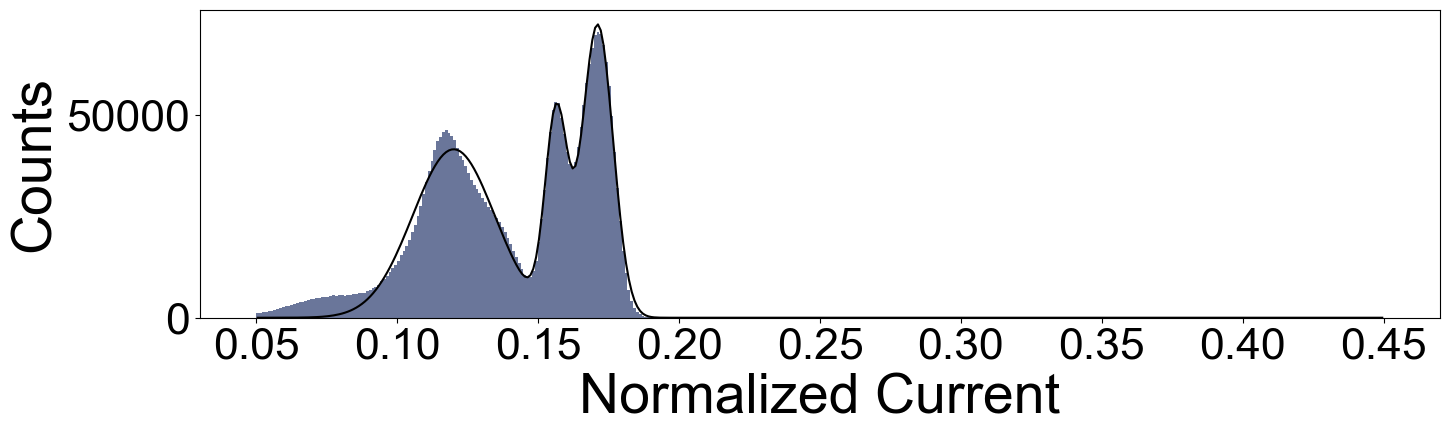

Peak 1: Amplitude = 0.72, Center = 0.1711, Sigma = 0.0055
Peak 2: Amplitude = 0.49, Center = 0.1564, Sigma = 0.0039
Peak 3: Amplitude = 0.42, Center = 0.1200, Sigma = 0.0146


In [12]:
# 定义通用的多高斯函数
def multi_gaussian(x, *params):
    """
    多高斯函数模型
    :param x: 自变量
    :param params: 参数列表，每三个参数代表一个高斯峰 (幅度、中心位置、标准差)
    :return: 多高斯函数的值
    """
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a, x0, sigma = params[i:i + 3]
        y += a * np.exp(-(x - x0)**2 / (2 * sigma**2))
    return y

# 动态生成初始参数猜测
def generate_initial_guess(num_peaks = 1, peak_centers = [0.5], peak_amp = [1.], peak_sigma = [0.01]):
    """
    根据指定的高斯峰数量生成初始参数猜测
    :param num_peaks: 高斯峰数量
    :param peak_centers: 直方图的 bin 中心位置
    :param peak_amp: 直方图的计数值
    :return: 初始参数列表
    """
    initial_guess = []
    peak_indices = np.linspace(0, len(peak_centers) - 1, num_peaks + 2)[1:-1].astype(int)
    for idx in peak_indices:
        amplitude = peak_amp[idx]
        center = peak_centers[idx]
        sigma = peak_sigma[idx]  # 默认标准差
        initial_guess.extend([amplitude, center, sigma])
    return initial_guess

fig = plt.figure(figsize=(16, 4))
counts, bins, patches = plt.hist(pySNA.data[2:][:-2]/pySNA.baseline,
                                 bins=401, 
                                 range=(0.05,0.45),
                                 color=color, alpha=0.75,
                                 linewidth=0.5,
                                 log=False)  # <<< 对数频次
# 计算 bin 中心位置
bin_centers = (bins[:-1] + bins[1:]) / 2
# 生成初始参数 old G5P5
#num_peaks = 2
#initial_guess = generate_initial_guess(num_peaks = num_peaks, peak_centers = [0.15,0.18,0.16,0.18], peak_amp = [1.1e5,1.4e5,0.8e5,0.8e5], peak_sigma = [2e-3,2e-3,2e-3,2e-3])
# 生成初始参数 old G5P5
num_peaks = 3
initial_guess = generate_initial_guess(num_peaks = num_peaks, peak_centers = [0.18,0.16,0.12,0.18], peak_amp = [8e4,8e4,4e4,0.8e5], peak_sigma = [2e-3,2e-3,5e-3,2e-3])
# 设置参数边界
# 幅度 > 0, 中心位置在 [0.05, 0.45], 标准差 > 0
lower_bounds = [0, 0.05, 0] * num_peaks  # 下界
upper_bounds = [np.inf, 0.45, np.inf] * num_peaks  # 上界

# 拟合多高斯模型
try:
    popt, _ = curve_fit(multi_gaussian, bin_centers, counts, p0=initial_guess, bounds=(lower_bounds, upper_bounds))
    #print("Fitted Parameters:", popt)
except RuntimeError:
    print("Fitting failed. Please adjust the initial guess or data.")

# 绘制拟合结果
plt.plot(bin_centers, multi_gaussian(bin_centers, *popt), 'k-', label=f"{num_peaks}-Peak Gaussian Fit")

# 添加图例和标签
plt.xlabel("Normalized Current")
plt.ylabel("Counts")
plt.show()

# 输出拟合参数
for i in range(num_peaks):
    a, x0, sigma = popt[i * 3:(i + 1) * 3]
    print(f"Peak {i + 1}: Amplitude = {a/1e5:.2f}, Center = {x0:.4f}, Sigma = {sigma:.4f}")

In [13]:
np.savez("G5P5K.npz", counts=counts, bins=bins, segment_dwell=segment_dwell, segment_median=segment_median, segment_mean=segment_mean, segment_std=segment_std)